<h2>Imports<h2>

In [3]:
from scipy.fft import fft
from mutagen.wave import WAVE
from parselmouth.praat import call
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
import parselmouth
import noisereduce as nr

<h2>Features Processing<h2>

Get data frames

In [4]:
def get_length(path, type):
    audio = WAVE(f'./wav_files/{type}/' + path)
    audio_info = audio.info
    return audio_info.length

train_df = pd.read_csv('./wav_files/train/train_data.csv')
train_df['Length'] = train_df['paths'].apply(lambda x: get_length(x, 'train'))

test_df = pd.read_csv('./wav_files/test/test_data.csv')
test_df['Length'] = test_df['paths'].apply(lambda x: get_length(x, 'test'))

validation_df = pd.read_csv('./wav_files/validation/validation_data.csv')
validation_df['Length'] = validation_df['paths'].apply(lambda x: get_length(x, 'validation'))

MFCCs

In [12]:
def get_Normalized_Mfccs(data, sample_rate):
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=25)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    mfccs_normalized = ((mfccs.T - mfccs_mean).T) / mfccs_std[:, np.newaxis]
    return mfccs_normalized

Spectral measurements

In [13]:
def get_spectral_measurements(data, sample_rate):
    spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=data)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate)
    return (spectral_centroids, spectral_rolloff, spectral_bandwidth, spectral_flatness, spectral_contrast)


Pitch sequence

In [14]:
# Extract the pitch sequence
def get_pitch_sequences(data, sample_rate):
    pitches, magnitudes = librosa.core.piptrack(y=data, sr=sample_rate)
    # Select the dominant pitch at each frame
    pitch_track = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        pitch_track.append(pitch)

    pitch_track = np.array(pitch_track)

    # Remove zeros values (unvoiced frames)
    pitch_track = pitch_track[pitch_track > 0]
    return pitch_track

Formants

In [15]:
### Get formants data ###
def get_formants(path):
    audio = parselmouth.Sound(path)
    formants = audio.to_formant_burg()
    number_points = int(audio.duration / 0.01) + 1
    formant_data = {'time': [], 'F1': [], 'F2': [], 'F3': []}
    for i in range(number_points):
        time = i * 0.01
        formant_data['time'].append(time)
        formant_data['F1'].append(formants.get_value_at_time(1, time))
        formant_data['F2'].append(formants.get_value_at_time(2, time))
        formant_data['F3'].append(formants.get_value_at_time(3, time))

    return formant_data


RMS and ZCR

In [16]:
### Energy and Amplitude Features ###

def get_rms_energy(data):
    # Root Mean Square (RMS) Energy - with a frame length of 2048 (default)
    return librosa.feature.rms(y=data, frame_length=2048, hop_length=512)

def get_ZCR(data):
    # Zero-Crossing Rate (ZCR) - with a frame length of 2048 (default)
    return librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512)

HNR

In [17]:
### Voice Quality Features ###
def get_HNR(data, sample_rate):
    # Load the cleaned sound into parselmouth.Sound
    snd = parselmouth.Sound(data, sample_rate)
    # Harmonics-to-Noise Ratio (HNR)
    hnr = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    #print(hnr)
    hnr_mean = call(hnr, "Get mean", 0, 0)
    return hnr_mean

Features matrix

In [18]:
attributes_df = pd.DataFrame()
training_audios = train_df['paths'].tolist()
test_audios = test_df['paths'].tolist()
validation_audios = validation_df['paths'].tolist()

for audio in validation_audios:
    path = './wav_files/validation/' + audio
    print(path)
    #sample_rate represent the number of samples per seconds in the original signal.
    data, sample_rate = librosa.load(path, sr=None)
    #clean data
    data = nr.reduce_noise(y=data, sr=sample_rate)

    #Get the attributes
    mfccs = get_Normalized_Mfccs(data, sample_rate)
    specs_measurements = get_spectral_measurements(data, sample_rate)
    pitch_track = get_pitch_sequences(data, sample_rate)
    formants_data = get_formants(path)
    rms_energy = get_rms_energy(data)
    zcr = get_ZCR(data)
    hnr_mean = get_HNR(data, sample_rate)

    row = pd.DataFrame({'Audio': audio ,'MFCCs': [np.array(mfccs)], 
                                'Spec Centroid': [specs_measurements[0]], 'Spec Rollof': [specs_measurements[1]],
                                'Spec Bandwidth': [specs_measurements[2]], 'Spec Flatness': [specs_measurements[3]], 
                                'Spec Contrast': [specs_measurements[4]], 'Pitch Track': [pitch_track],
                                'Formants': [formants_data], 'RMS Energy': [rms_energy],
                                'ZCR': [zcr], 'HNR Mean': [hnr_mean]})
    attributes_df = pd.concat([attributes_df, row], ignore_index=True)

matrix = attributes_df.values

./wav_files/validation/common_voice_ar_20939658.wav
./wav_files/validation/common_voice_ar_19493969.wav
./wav_files/validation/common_voice_ar_19629527.wav
./wav_files/validation/common_voice_ar_20439312.wav
./wav_files/validation/common_voice_ar_19220795.wav
./wav_files/validation/common_voice_ar_19465378.wav
./wav_files/validation/common_voice_ar_19204978.wav
./wav_files/validation/common_voice_ar_19721653.wav
./wav_files/validation/common_voice_ar_19745588.wav
./wav_files/validation/common_voice_ar_19721692.wav
./wav_files/validation/common_voice_ar_19331812.wav
./wav_files/validation/common_voice_ar_20439359.wav
./wav_files/validation/common_voice_ar_19261957.wav
./wav_files/validation/common_voice_ar_19994904.wav
./wav_files/validation/common_voice_ar_19204982.wav
./wav_files/validation/common_voice_ar_19205103.wav
./wav_files/validation/common_voice_ar_19994851.wav
./wav_files/validation/common_voice_ar_19205026.wav
./wav_files/validation/common_voice_ar_19465379.wav
./wav_files/

KeyboardInterrupt: 

<h2>Features visualisation<h2>

Initialisation

In [19]:
data, sample_rate = librosa.load(path=f'./wav_files/validation/{validation_df['paths'][0]}')
data = nr.reduce_noise(y=data, sr=sample_rate)

MFCCs visualisation

(25, 131)


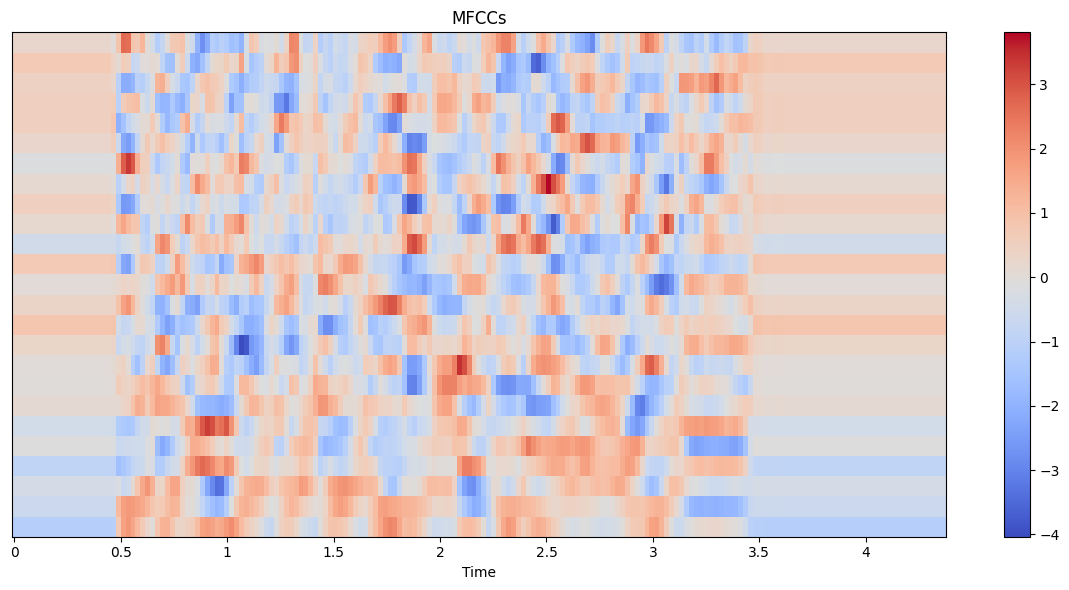

In [25]:
normalized_mfccs = get_Normalized_Mfccs(data, sample_rate)
print(mfccs.shape)
plt.figure(figsize=(12,6))
librosa.display.specshow(normalized_mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()

Spectral measurements visualisation

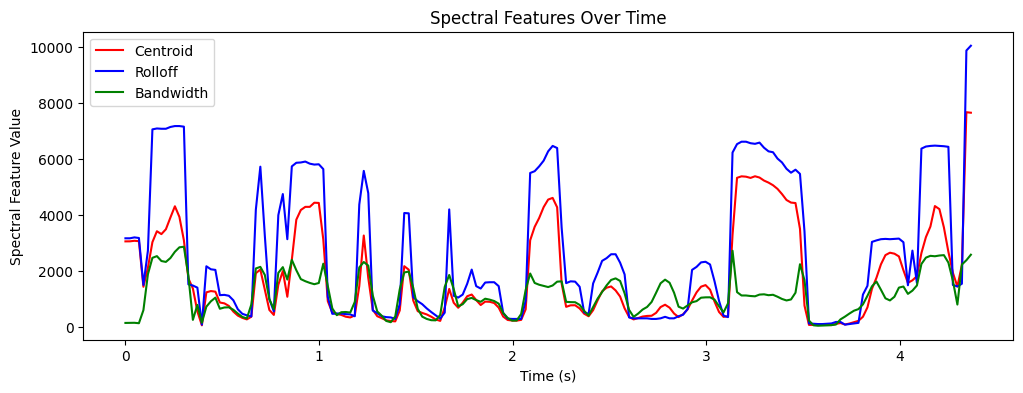

In [21]:
specs = get_spectral_measurements(data, sample_rate)

t = librosa.frames_to_time(range(len(specs[0])), sr=sample_rate)

# Plotting the Spectral Features
plt.figure(figsize=(12, 4))
plt.plot(t, specs[0], color='red', label='Centroid')
plt.plot(t, specs[1], color='blue', label='Rolloff')
plt.plot(t, specs[2], color='green', label='Bandwidth')

# For spectral flatness, there's no need to convert to dB since it's a ratio and typically small.
#plt.plot(t, spectral_flatness, color='orange', label='Flatness')

# For spectral contrast, it's common to average over the frequency bands since it returns an array of shape (n_bands, n_frames).
#spectral_contrast_avg = np.mean(spectral_contrast, axis=0)
#plt.plot(t, spectral_contrast_avg, color='black', label='Contrast')

plt.xlabel("Time (s)")
plt.ylabel("Spectral Feature Value")
plt.title("Spectral Features Over Time")
plt.legend(loc='best')
plt.show()

Pitches visualisation

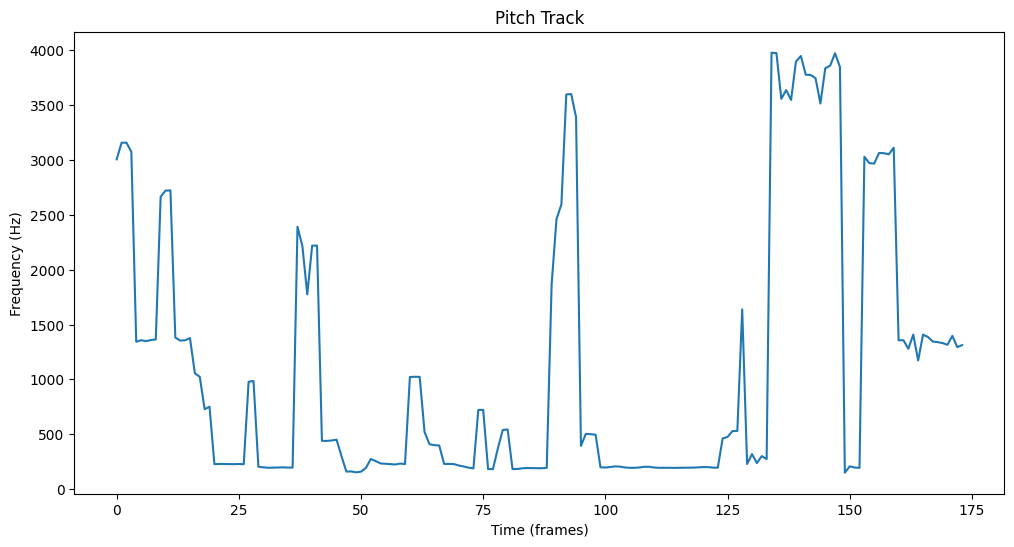

In [22]:
pitch_track = get_pitch_sequences(data, sample_rate)
plt.figure(figsize=(12, 6))
plt.plot(pitch_track)
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Track')
plt.show()

RMS Visualisation

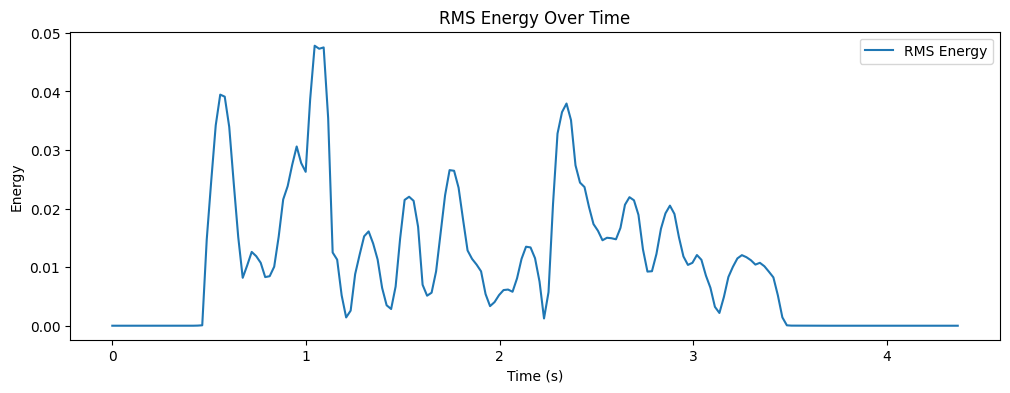

In [23]:
rms_energy = get_rms_energy(data)
frames = range(len(rms_energy[0]))
t = librosa.frames_to_time(frames, sr=sample_rate)

plt.figure(figsize=(12, 4))
plt.plot(t, rms_energy[0], label='RMS Energy')
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.title("RMS Energy Over Time")
plt.legend()
plt.show()